In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
normal_data = pd.read_csv('/content/drive/MyDrive/archive./ptbdb_normal.csv' , header=None)
abnormal_data = pd.read_csv('/content/drive/MyDrive/archive./ptbdb_abnormal.csv' , header=None)

In [30]:
normal_data['label'] = 0
abnormal_data['label'] = 1

In [31]:
combined_data = pd.concat([normal_data, abnormal_data], axis=0)

In [32]:
combined_data.drop(columns=187 , inplace = True)

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined_data.iloc[:, :-1] = scaler.fit_transform(combined_data.iloc[:, :-1])
combined_data

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.120875,0.111372,0.113303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.298069,0.328139,0.345866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.757909,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.078133,0.075470,0.077518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.049490,0.054850,0.041737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.097809,0.094074,0.101057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.950525,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.247414,0.244419,0.250836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10502,0.750514,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.534962,0.484133,0.443544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.082587,0.075380,0.089983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.280427,0.262823,0.259108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Trainable weights for attention mechanism
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],),
                                 initializer="zeros", trainable=True)
        self.u = self.add_weight(name="att_u", shape=(input_shape[-1],),
                                 initializer="glorot_uniform", trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Score computation
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu)

        # Weighted sum of input
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output, alphas

In [38]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)

    # Bi-LSTM layer
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(inputs)

    # Add Attention layer
    attention_out, attention_weights = AttentionLayer()(lstm_out)

    # Final Dense layer
    outputs = Dense(1, activation='sigmoid')(attention_out)

    # Define the model
    model = Model(inputs, outputs)
    return model

input_shape = (187, 1)
model = create_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision' , 'recall'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 187, 128)            │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_3 (AttentionLayer)   │ [(None, 128), (None, 187)]  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,561 (197.50 KB)

 Trainable params: 50,561 (197.50 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
X = combined_data.iloc[:, :-1]
y = combined_data['label']

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42 , shuffle=True)

In [41]:
import numpy as np
print(X_train.shape)
print(X_val.shape)
X_train = np.array(X_train).reshape(-1, 187, 1)
X_val = np.array(X_val).reshape(-1, 187, 1)

(10186, 187)
(4366, 187)


In [42]:
model.fit(X_train, y_train,validation_data=(X_val,y_val) ,epochs=15, batch_size=45)

Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.7247 - loss: 0.5854 - precision: 0.7247 - recall: 1.0000 - val_accuracy: 0.7199 - val_loss: 0.5296 - val_precision: 0.7199 - val_recall: 1.0000
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 81s 263ms/step - accuracy: 0.7184 - loss: 0.5376 - precision: 0.7187 - recall: 0.9986 - val_accuracy: 0.7201 - val_loss: 0.5132 - val_precision: 0.7200 - val_recall: 1.0000
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step - accuracy: 0.7339 - loss: 0.5049 - precision: 0.7521 - recall: 0.9420 - val_accuracy: 0.7506 - val_loss: 0.4674 - val_precision: 0.7464 - val_recall: 0.9898
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 84s 262ms/step - accuracy: 0.7828 - loss: 0.4476 - precision: 0.8121 - recall: 0.9122 - val_accuracy: 0.7815 - val_loss: 0.4176 - val_precision: 0.9182 - val_recall: 0.7646
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 77s 238ms/step - accuracy: 0.7891 - loss: 0.4236 - precision: 0.8508 - recall: 0.8582 - val_accuracy: 0.8019

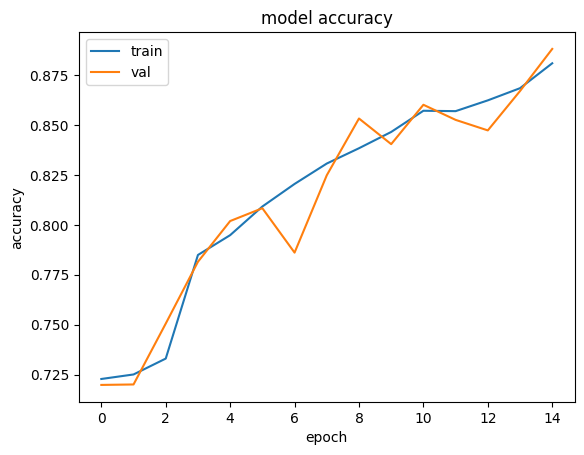

In [43]:
from tensorflow import keras
from matplotlib import pyplot as plt
history = model.history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()